---
# Data Collection
---

In [144]:
# These values can be changed to the requested ticker and parameters 

ticker = 'GS'
from_date = '2010-01-01'
to_date = '2018-12-31'
type = 'line'

competitors = ['JPM', 'MS', 'C', 'BCS', 'CS', 'UBS', 'DB']


In [145]:
# Helper: Financial API helper functions    #

from urllib.request import urlopen
import urllib.parse
import json

# Get JSON data from the requested url
def get_json_data(url):
    response = urlopen(url)
    response = response.read().decode("utf-8")
    return json.loads(response)

# Conver the provided parameters into FMP url
def get_url(ticker, from_date = None, to_date = None, type = None):
    url = "https://financialmodelingprep.com/api/v3/historical-price-full/" + urllib.parse.quote(ticker, safe='=:/&?') + "?"
    
    params = ''
    if from_date != None:
        params += 'from=' + from_date + "&"
    if to_date != None:
        params += 'to=' + to_date + '&'
    if type != None:
        params += 'serietype=' + type + '&'

    return url + urllib.parse.quote(params[:-1], safe='=:/&?')

json_data = get_json_data(get_url(ticker, from_date, to_date, type))


In [146]:
# Write ticker data to file as csv #
import csv

# Write JSON data to csv file
data_file = open('dataset.csv', 'w+')
outputWriter = csv.writer(data_file, delimiter=',')

outputWriter.writerow(['date', ticker])
for obj in json_data['historical']:
    outputWriter.writerow([obj['date'] , obj['close']])

data_file.close()

---
# Data Preprocessing
---



In [147]:
# Supposedly all imports

# from utils import *

import time
import numpy as np

import pandas as pd

# from mxnet import nd, autograd, gluon
# from mxnet.gluon import nn, rnn
# import mxnet as mx
import datetime
# import seaborn as sns

import matplotlib.pyplot as plt
# %matplotlib inline
# from sklearn.decomposition import PCA

# import math

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler

# import xgboost as xgb
# from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Optional: Print timeseries of data #

complete_dataset = pd.read_csv('dataset.csv')
total_days = complete_dataset.shape[0]
num_training_days = int(total_days * .7)
num_testing_days = total_days-num_training_days
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, num_testing_days))

# Print timeseries of {ticker}

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(complete_dataset['date'], complete_dataset[ticker], label='{ticker} stock')
plt.vlines(str(datetime.date(2016, 4, 20)), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [157]:
# Helper: Appends additional features to main data file #

def merge_data(json_data):
    diff1 = pd.read_csv('dataset.csv')
    diff2 = pd.DataFrame(json_data)

    cols_to_use = diff2.columns.difference(diff1.columns)
    print(cols_to_use)
    diff = diff1.merge(diff2, on='date', right_index=True, left_index=True,how='outer')
    diff.to_csv('dataset.csv', index=False)
    

## Correlated Assets
---

### Similar Companies or Competitors

In [152]:
# Add similar companies data to dataset #

json_data = None

for c in competitors:
    json_data = get_json_data(get_url(c, from_date, to_date, type))
    
    # Change 'close' to the company name
    json_data = json_data['historical']
    for i in range(len(json_data)):
        json_data[i][c] = json_data[i].pop('close')

    merge_data(json_data)


### Volatility Index

In [160]:
# Add volatility index to the dataset #

json_data = None

json_data = get_json_data(get_url('index/^VIX', from_date, to_date, type))

# Change 'close' to the volatility index
json_data = json_data['historical']
for i in range(len(json_data)):
    json_data[i]['^VIX'] = json_data[i].pop('close')

merge_data(json_data)

Index(['^VIX'], dtype='object')


### Global Economic Indices

### Composite Indices (S&P500, DOW, NASDAQ, BSE Sensex, FTSE100, Nikkei225)

In [ ]:
# Add major worldwide indexes to dataset #

major_indices = ['^DJI', '^IXIC', '^GSPC', '^BSESN', '^FTSE', '^N225', '^HSI', '^BVSP', '^BUK100P', '^N100']

json_data = None

for ind in major_indices:
    json_data = get_json_data(get_url('index/' + c, from_date, to_date, type))
   
    # Change 'close' to the volatility index
    json_data = json_data['historical']
    for i in range(len(json_data)):
        json_data[i][ind] = json_data[i].pop('close')

    merge_data(json_data)

### Currencies

In [ ]:

# Add ForEx data to dataset

currencies = ['USDJPY', 'USDGBP', 'USDEUR', 'USDCHF', 'USDCAD']

json_data = None

for c in currencies:
    json_data = get_json_data(get_url('forex/' + c, from_date, to_date, type))

    # Change 'close' to the volatility index
    json_data = json_data['historical']
    for i in range(len(json_data)):
        json_data[i][c] = json_data[i].pop('close')

    merge_data(json_data)

## Technical Indicators
---


In [ ]:
complete_dataset = pd.read_csv('dataset.csv')

In [117]:
import math

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['GS'].rolling(window=7).mean()
    dataset['ma21'] = dataset['GS'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['GS'].ewm(span=26).mean()
    dataset['12ema'] = dataset['GS'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['GS'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['GS'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['GS'] - 1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset

technical_dataset = get_technical_indicators(complete_dataset[['GS']])


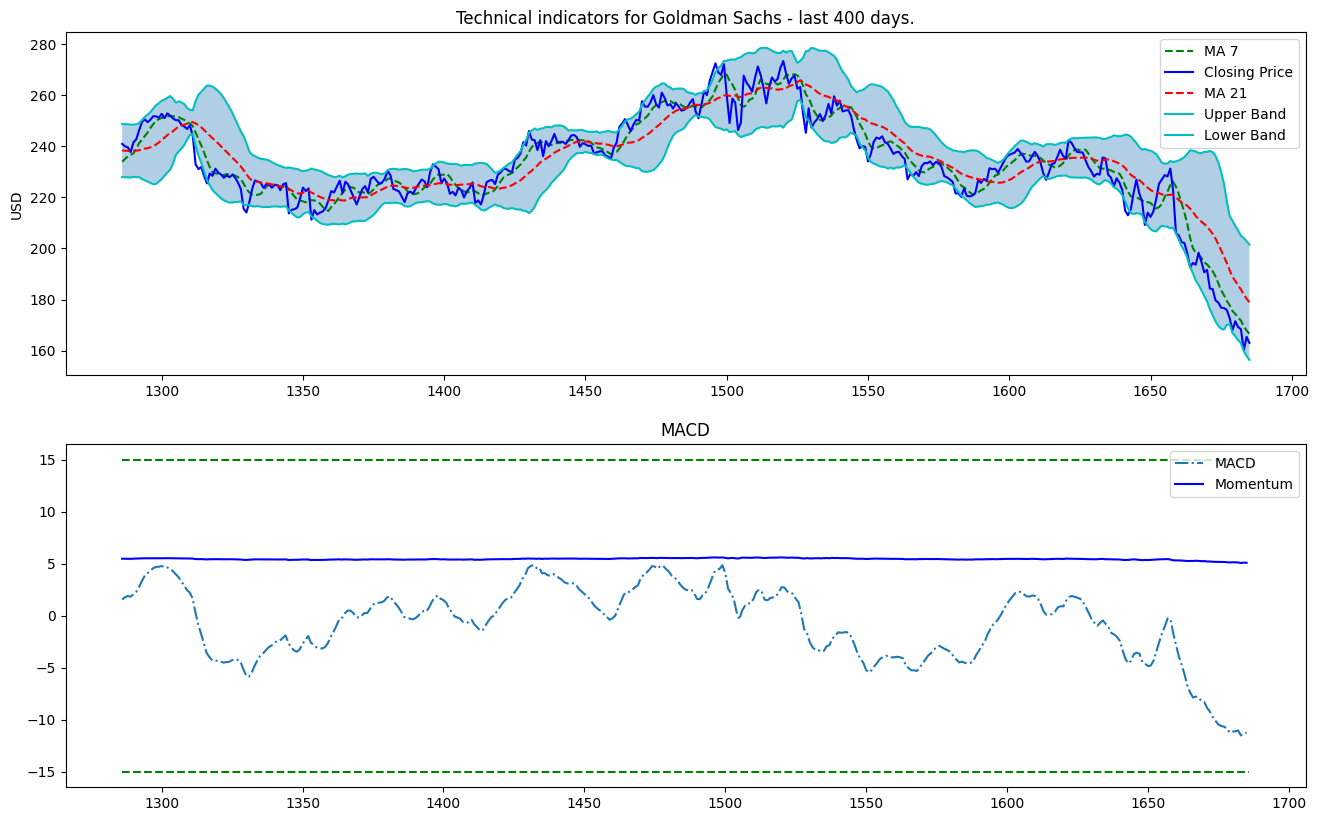

In [121]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['GS'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
plot_technical_indicators(technical_dataset, 400)


## Fundamental Analysis
---

### Company Analysis

### Sentiment Analysis

## Trend Analysis
---

In [123]:
fourier_dataset = complete_dataset[['date', 'GS']]

close_fft = np.fft.fft(np.asarray(fourier_dataset['GS'].tolist()))
fft = pd.DataFrame({'fft':close_fft})
fft['absolute'] = fft['fft'].apply(lambda x: np.abs(x))
fft['angle'] = fft['fft'].apply(lambda x: np.angle(x))


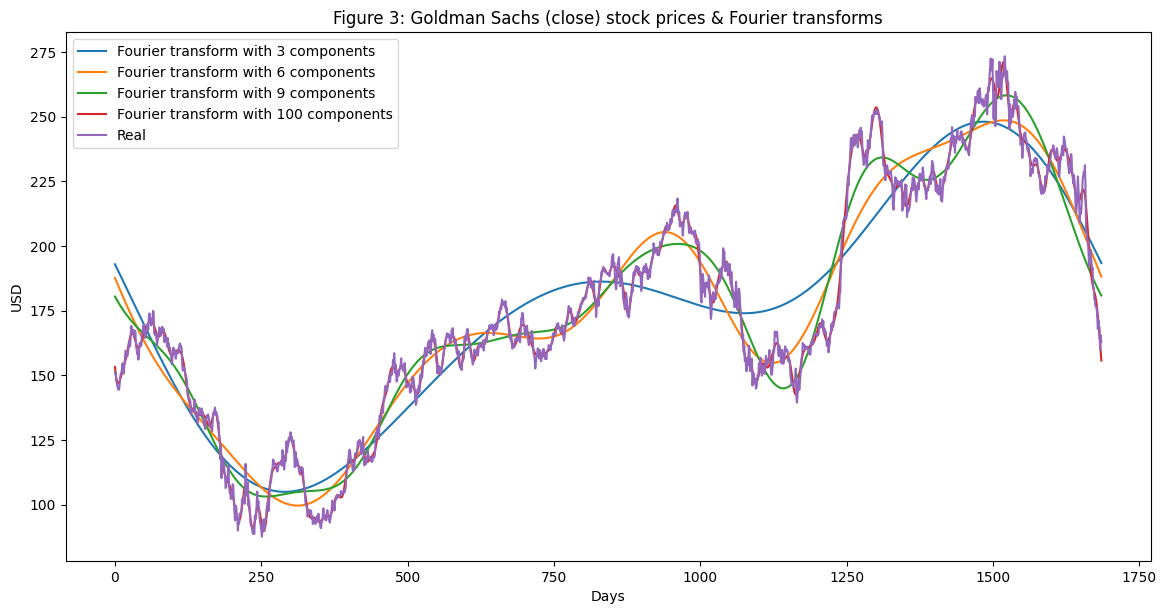

In [132]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(fourier_dataset['GS'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()